# 2. Select and preprocess data

This notebook, part of the ETL phase of the project, performs the following steps:

1. Load the original HateXplain dataset.
2. Analyze the agreement in labelling between annotators.
3. Select the instances where two or three annotators agree, and decide the label by majority voting.
4. Only keep the instances labeled as "normal" or "hatespeech", to create a dataset for a binary classification task.
5. Save this preprocessed dataset for descriptive analysis.
6. Split the dataset into train, validation and test and save for posterior use.

In [ ]:
# Necessary imports
import json
import numpy as np
import polars as pl
import re
import sys
import unicodedata

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

# Get the absolute path of the project's root directory
ROOT_DIR = Path.resolve(Path.cwd() / "../")

# Add root directory to sys.path
sys.path.append(str(ROOT_DIR))

from src.utils.set_seed import set_seed

# Set the seed for reproducibility
rng = set_seed()


In [ ]:
# Directory management
DATA_DIR = ROOT_DIR / "data"
NATIVE_DATA_DIR = DATA_DIR / "native"
PREPROCESSED_DATA_DIR = DATA_DIR / "preprocessed"
SPLITTED_DATA_DIR = DATA_DIR / "splitted"


### 1. Load the HateXplain Dataset

In [4]:
# Load the dataframe
df_dataset = pl.read_parquet(PREPROCESSED_DATA_DIR / "dataset_native.parquet")
display(df_dataset)


post_id,labels,targets,tokens,rationales
str,list[str],list[list[str]],list[str],list[list[f32]]
"""1179055004553900032_twitter""","[""normal"", ""normal"", ""normal""]","[[""None""], [""None""], [""None""]]","[""i"", ""dont"", … ""touched""]",[]
"""1179063826874032128_twitter""","[""normal"", ""normal"", ""normal""]","[[""None""], [""None""], [""None""]]","[""we"", ""cannot"", … ""forum""]",[]
"""1178793830532956161_twitter""","[""normal"", ""normal"", ""hatespeech""]","[[""African""], [""None""], [""African""]]","[""nawt"", ""yall"", … ""me""]",[]
"""1179088797964763136_twitter""","[""hatespeech"", ""offensive"", ""hatespeech""]","[[""Asian""], [""Asian""], [""Asian""]]","[""<user>"", ""i"", … ""🤔""]","[[0.0, 0.0, … 0.0], [0.0, 0.0, … 0.0], [0.0, 0.0, … 0.0]]"
"""1179085312976445440_twitter""","[""hatespeech"", ""hatespeech"", ""offensive""]","[[""Caucasian"", ""Women""], [""Women"", ""Caucasian""], [""Women"", ""Caucasian""]]","[""this"", ""bitch"", … ""bitches""]","[[0.0, 1.0, … 0.0], [0.0, 0.0, … 1.0], [0.0, 1.0, … 1.0]]"
…,…,…,…,…
"""9989999_gab""","[""offensive"", ""offensive"", ""normal""]","[[""Men"", ""Women"", ""Other""], [""None""], [""None""]]","[""if"", ""ur"", … ""😡""]","[[0.0, 0.0, … 0.0], [0.0, 0.0, … 0.0]]"
"""9990225_gab""","[""offensive"", ""offensive"", ""normal""]","[[""African""], [""African"", ""Other""], [""None""]]","[""when"", ""i"", … ""ok""]","[[0.0, 0.0, … 0.0], [0.0, 0.0, … 0.0]]"
"""9991681_gab""","[""offensive"", ""normal"", ""normal""]","[[""Islam""], [""Other""], [""None""]]","[""was"", ""macht"", … ""hetzen""]",[]


### 2. Check the agreement in labelling between the annotators.

As will be seen below, each data instance is labelled and analyzed by 3 independent annotators. Here, we will analyze the agreement between these annotators, in order to assign a unique label to each data instance.


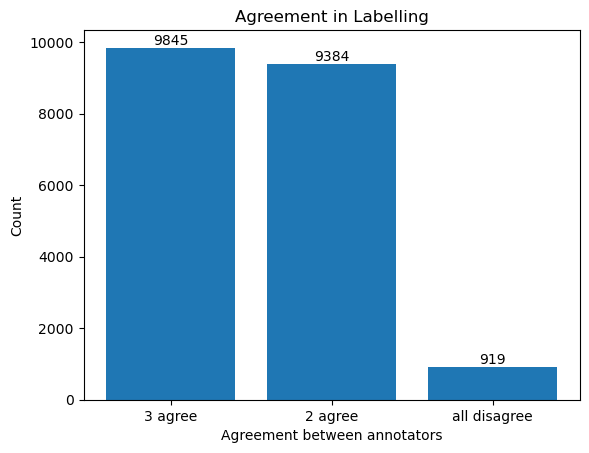

In [5]:
# Check the agreement in labelling between the independent annotators
df_dataset = df_dataset.with_columns(
    pl.col("labels").map_elements(lambda x: len(set(x)), return_dtype=pl.Int8).alias("label_agreement")
)

value_counts = df_dataset["label_agreement"].value_counts()
x = sorted(value_counts["label_agreement"].to_list())
y = sorted(value_counts["count"].to_list())

plt.bar(x[::-1], y)
plt.text(3, y[0] + 400, f"{y[0]}", ha="center", va="top")
plt.text(2, y[1] + 400, f"{y[1]}", ha="center", va="top")
plt.text(1, y[2] + 400, f"{y[2]}", ha="center", va="top")
plt.xlabel("Agreement between annotators")
plt.ylabel("Count")

plt.xticks([1, 2, 3], labels=["3 agree", "2 agree", "all disagree"])

plt.title("Agreement in Labelling")
plt.show()


As we can see, the number of instances where all three annotators disagree in the labelling ins residual. We will ignore these instances and work only with the ones where two or three annotators agree.

### 3. Select the instances where two or three annotators agree, and decide the label by majority voting.

Here, we select only the instances where two or three annotators agree, and compute the unique label of the instance by majority voting.

In [6]:
# Only keep the samples where all annotators agree
df_dataset = df_dataset.filter(pl.col("label_agreement").is_in([1, 2]))
df_dataset = df_dataset.drop("label_agreement")

# Apply majority voting to determine the final label
df_dataset = df_dataset.with_columns(
    pl.col("labels").map_elements(lambda x: max(set(x.to_list()), key=x.to_list().count)),
)

df_dataset = df_dataset.rename({"labels": "label"})
df_dataset.head()



/tmp/ipykernel_46101/2294918788.py:6: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df_dataset = df_dataset.with_columns(


post_id,label,targets,tokens,rationales
str,str,list[list[str]],list[str],list[list[f32]]
"""1179055004553900032_twitter""","""normal""","[[""None""], [""None""], [""None""]]","[""i"", ""dont"", … ""touched""]",[]
"""1179063826874032128_twitter""","""normal""","[[""None""], [""None""], [""None""]]","[""we"", ""cannot"", … ""forum""]",[]
"""1178793830532956161_twitter""","""normal""","[[""African""], [""None""], [""African""]]","[""nawt"", ""yall"", … ""me""]",[]
"""1179088797964763136_twitter""","""hatespeech""","[[""Asian""], [""Asian""], [""Asian""]]","[""<user>"", ""i"", … ""🤔""]","[[0.0, 0.0, … 0.0], [0.0, 0.0, … 0.0], [0.0, 0.0, … 0.0]]"
"""1179085312976445440_twitter""","""hatespeech""","[[""Caucasian"", ""Women""], [""Women"", ""Caucasian""], [""Women"", ""Caucasian""]]","[""this"", ""bitch"", … ""bitches""]","[[0.0, 1.0, … 0.0], [0.0, 0.0, … 1.0], [0.0, 1.0, … 1.0]]"


### 4. Only keep the instances labeled as "normal" or "hatespeech", to create a dataset for a binary classification task.

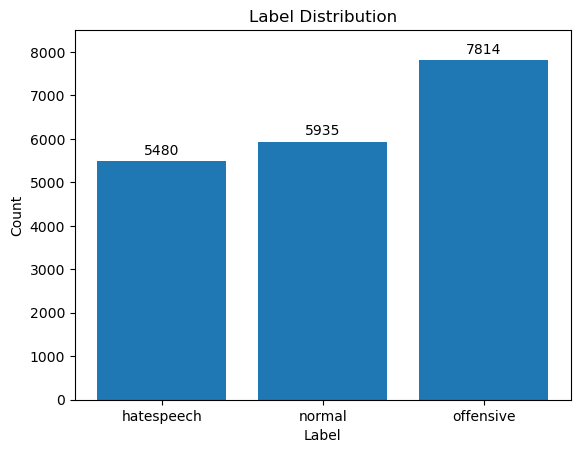

In [7]:
# Check the distribution of the labels
value_counts = df_dataset["label"].value_counts()

x = sorted(value_counts["label"].to_list())
y = sorted(value_counts["count"].to_list())

plt.bar(x, y)
plt.text(0, y[0] + 400, f"{y[0]}", ha="center", va="top")
plt.text(1, y[1] + 400, f"{y[1]}", ha="center", va="top")
plt.text(2, y[2] + 400, f"{y[2]}", ha="center", va="top")

plt.ylim(0, 8500)
plt.xlabel("Label")
plt.ylabel("Count")

plt.title("Label Distribution")
plt.show()


In [8]:
# Select only the samples with the labels "normal" and "hatespeech"
df_dataset_2_classes = df_dataset.filter(pl.col("label").is_in(["normal", "hatespeech"]))
df_dataset_2_classes.head()


post_id,label,targets,tokens,rationales
str,str,list[list[str]],list[str],list[list[f32]]
"""1179055004553900032_twitter""","""normal""","[[""None""], [""None""], [""None""]]","[""i"", ""dont"", … ""touched""]",[]
"""1179063826874032128_twitter""","""normal""","[[""None""], [""None""], [""None""]]","[""we"", ""cannot"", … ""forum""]",[]
"""1178793830532956161_twitter""","""normal""","[[""African""], [""None""], [""African""]]","[""nawt"", ""yall"", … ""me""]",[]
"""1179088797964763136_twitter""","""hatespeech""","[[""Asian""], [""Asian""], [""Asian""]]","[""<user>"", ""i"", … ""🤔""]","[[0.0, 0.0, … 0.0], [0.0, 0.0, … 0.0], [0.0, 0.0, … 0.0]]"
"""1179085312976445440_twitter""","""hatespeech""","[[""Caucasian"", ""Women""], [""Women"", ""Caucasian""], [""Women"", ""Caucasian""]]","[""this"", ""bitch"", … ""bitches""]","[[0.0, 1.0, … 0.0], [0.0, 0.0, … 1.0], [0.0, 1.0, … 1.0]]"


### 5. Replace special unicode characters with special tokens

In [9]:
# Replace the character `\u200[df]` with the token `<u200[df]>`
df_dataset_2_classes = df_dataset_2_classes.with_columns(
    pl.col("tokens").map_elements(
        lambda tokens: [token.replace("\u200d", "<u200d>") for token in tokens],
        return_dtype=pl.List(pl.String),
        ).alias("tokens"),
)

df_dataset_2_classes = df_dataset_2_classes.with_columns(
    pl.col("tokens").map_elements(
        lambda tokens: [token.replace("\u200f", "<u200f>") for token in tokens],
        return_dtype=pl.List(pl.String),
        ).alias("tokens"),
)

# Replace accented characters with the original characters
def remove_accents(token: str) -> str:
    """Remove accents from tokens."""
    # Only process tokens that contain alphabetic characters
    if re.search(r"[a-zA-ZÀ-ÖØ-öø-ÿ]", token):
        return "".join(
            c if not unicodedata.category(c).startswith("L")
            else unicodedata.normalize("NFKD", c).encode("ASCII", "ignore").decode("utf-8")
            for c in token
        )
    return token  # Keep other tokens unchanged


df_dataset_2_classes = df_dataset_2_classes.with_columns(
    pl.col("tokens").map_elements(
        lambda tokens: [remove_accents(token) for token in tokens],
        return_dtype=pl.List(pl.String),
        ).alias("tokens"),
)





### 7. Generate a unique rationale from the different annotations

In [10]:
# Take the mean of the rationales
df_dataset_2_classes = df_dataset_2_classes.with_columns(
    pl.col("rationales").map_elements(
        lambda rationales: (
            np.mean(np.array(rationales), axis=0)
            if len(rationales) > 0
            else np.array([])
        ),
        return_dtype=pl.List(pl.Float32),
    ).alias("rationale"),
)

# Normalize the rationales
df_dataset_2_classes = df_dataset_2_classes.with_columns(
    pl.col("rationale").map_elements(
        lambda rationale: (
            np.array(rationale, dtype=np.float32) / np.sum(np.array(rationale, dtype=np.float32))
            if np.sum(np.array(rationale, dtype=np.float32)) > 0
            else np.array(rationale, dtype=np.float32)
        ),
        return_dtype=pl.List(pl.Float32),
    ).alias("rationale"),
)


### 8. Save the preprocessed dataset

In [11]:
df_dataset_2_classes.write_parquet(PREPROCESSED_DATA_DIR / "dataset_preprocessed_2_classes.parquet")


### 9. Split the dataset into train, validation and test and save for posterior use

We will perform the splitting of the dataset into train / validation / test sets by using the division provided by the HateXplain developers, which ensures an approximate 8:1:1 division ratio. The information of the belonging of each class to a particular subset is containted in the `post_id_divisions.json` file.

In [12]:
# Train / Validation / Test Split

with Path.open(NATIVE_DATA_DIR / "post_id_divisions.json", "r") as file:
    splits = json.load(file)

train_ids = splits["train"]
val_ids = splits["val"]
test_ids = splits["test"]


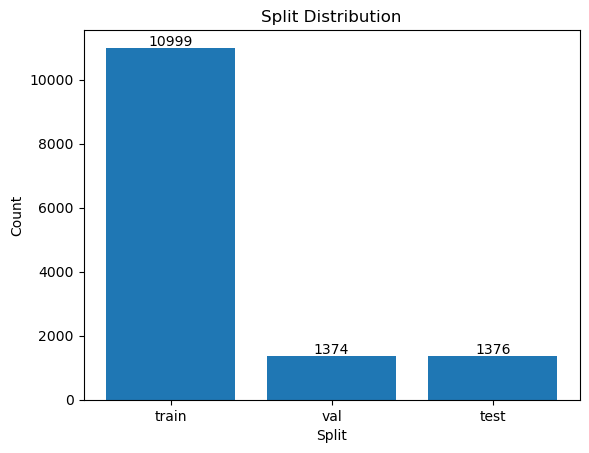

In [13]:
# Check what instances of the dataset belong to each split and create a column accounting so
df_dataset_2_classes = df_dataset_2_classes.with_columns(
        pl.when(
            pl.col("post_id").is_in(train_ids),
        ).then(pl.lit("train"))

        .when(
            pl.col("post_id").is_in(val_ids),
        ).then(pl.lit("val"))

        .when(
            pl.col("post_id").is_in(test_ids),
        ).then(pl.lit("test"))

        .otherwise(pl.lit("unknown"))

    .alias("split"),
)

value_counts = df_dataset_2_classes["split"].value_counts()

x = value_counts["split"].to_list()
y = value_counts["count"].to_list()

plt.bar(x, y)
plt.text(0, y[0] + 400, f"{y[0]}", ha="center", va="top")
plt.text(1, y[1] + 400, f"{y[1]}", ha="center", va="top")
plt.text(2, y[2] + 400, f"{y[2]}", ha="center", va="top")

plt.xlabel("Split")
plt.ylabel("Count")

plt.title("Split Distribution")
plt.show()


In [ ]:
# Save each split as a separate parquet file
df_train_2_classes = (
    df_dataset_2_classes
    .filter(pl.col("split") == "train")
    .drop("split")
    .sort("label")
)

df_val_2_classes = (
    df_dataset_2_classes
    .filter(pl.col("split") == "val")
    .drop("split")
    .sort("label")
)

df_test_2_classes = (
    df_dataset_2_classes
    .filter(pl.col("split") == "test")
    .drop("split")
    .sort("label")
)


In [ ]:
df_train_2_classes.write_parquet(SPLITTED_DATA_DIR / "train_2_classes.parquet")
df_val_2_classes.write_parquet(SPLITTED_DATA_DIR / "val_2_classes.parquet")
df_test_2_classes.write_parquet(SPLITTED_DATA_DIR / "test_2_classes.parquet")
